# Deep Criminal Sketch Artist - Attempt 1
### References
Model: https://arxiv.org/pdf/1803.11404.pdf

VAES: https://github.com/mhw32/multimodal-vae-public (https://github.com/mhw32/multimodal-vae-public) https://arxiv.org/abs/1312.6114

### Setup

In [1]:
# Imports
import os
import sys
import random
import numpy as np
import numpy.random as npr
from PIL import Image
from random import shuffle
import math 
# Pytorch
import torch
import torch.nn as nn
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from torch.autograd import Variable
from torch.nn import functional as F
# Plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

### Check if running on GPU

In [2]:
dtype = torch.float
if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

print('using device:', device)

using device: cuda:0


### Set path to where CelebA is downloaded
Needs to include everything here: https://drive.google.com/drive/folders/0B7EVK8r0v71pWEZsZE9oNnFzTm8

In [3]:
dataset_path = '/home/sci/jadie/Data/CelebA/'

### Define dataset class with images and attributes

In [4]:
PARTITIONS = {'train': 0, 'val': 1, 'test': 2}

class CelebAttributes(Dataset):
    def __init__(self, partition='train', data_dir='/home/sci/jadie/Data/CelebA/'):
        self.partition = partition
        self.data_dir = data_dir
        self.image_paths = load_eval_partition(partition, data_dir=data_dir)
        self.attr_data = load_attributes(self.image_paths, partition, data_dir=data_dir)
        self.size = int(len(self.image_paths))

    def __getitem__(self, index):
        image_path = os.path.join(self.data_dir, 'img_align_celeba', self.image_paths[index])
        attr = self.attr_data[index]
        image = Image.open(image_path).convert('RGB')
        image_transform = transforms.Compose([transforms.Resize(64),transforms.CenterCrop(64),transforms.ToTensor()])
        image =image_transform(image)
        return image, attr

    def __len__(self):
        return self.size


def load_eval_partition(partition, data_dir='/home/sci/jadie/Data/CelebA/'):
    eval_data = []
    with open(os.path.join(data_dir, 'Eval/list_eval_partition.txt')) as fp:
        rows = fp.readlines()
        for row in rows:
            path, label = row.strip().split(' ')
            label = int(label)
            if label == PARTITIONS[partition]:
                eval_data.append(path)
    return eval_data


def load_attributes(paths, partition, data_dir='/home/sci/jadie/Data'):
    attr_data = []
    with open(os.path.join(data_dir, 'Anno/list_attr_celeba.txt')) as fp:
        rows = fp.readlines()
        for ix, row in enumerate(rows[2:]):
            row = row.strip().split()
            path, attrs = row[0], row[1:]
            if path in paths:
                attrs = np.array(attrs).astype(int)
                attrs[attrs < 0] = 0
                attr_data.append(attrs)
    attr_data = np.vstack(attr_data).astype(np.int64)
    attr_data = torch.from_numpy(attr_data).float()
    return attr_data

### Get train and validation loaders
This takes a little while to run

In [5]:
celeba_train = CelebAttributes(partition='train', data_dir=dataset_path)
train_loader = torch.utils.data.DataLoader(celeba_train, batch_size=100, shuffle=True)
print("Number of training examples: " + str(len(celeba_train)))

celeba_val = CelebAttributes(partition='val', data_dir=dataset_path)
val_loader = torch.utils.data.DataLoader(celeba_val, batch_size=100, shuffle=False)
print("Number of validation examples: " + str(len(celeba_val)))

celeba_test = CelebAttributes(partition='test', data_dir=dataset_path)
test_loader = torch.utils.data.DataLoader(celeba_test, batch_size=100, shuffle=False)
print("Number of test examples: " + str(len(celeba_test)))

Number of training examples: 162770
Number of validation examples: 19867
Number of test examples: 19962


#### Visualize a batch of training images

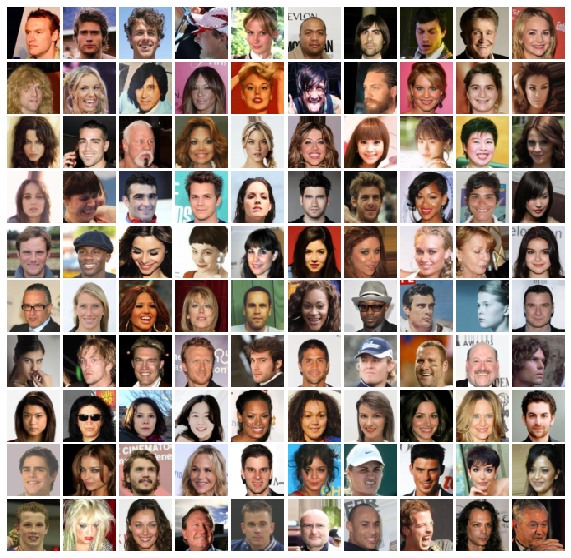

In [6]:
def show_images(images):
  sqrtn = int(math.ceil(math.sqrt(images.shape[0])))
  sqrtimg = int(math.ceil(math.sqrt(images.shape[1])))

  fig = plt.figure(figsize=(sqrtn, sqrtn))
  gs = gridspec.GridSpec(sqrtn, sqrtn)
  gs.update(wspace=0.05, hspace=0.05)

  for i, img in enumerate(images):
    ax = plt.subplot(gs[i])
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(img.permute(1,2,0))
  return 

imgs = train_loader.__iter__().next()[0].view(100, 3, 64, 64)
show_images(imgs)

## Define Model

In [7]:
# q(z|image)
class ImageEncoder(nn.Module):
    def __init__(self, n_latents):
        super(ImageEncoder, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1, bias=False),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Conv2d(128, 256, 4, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU())
        self.classifier = nn.Sequential(
            nn.Linear(256 * 5 * 5, 512),
            nn.LeakyReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(512, n_latents * 2))
        self.n_latents = n_latents
    def forward(self, x):
        n_latents = self.n_latents
        x = self.features(x)
        x = x.view(-1, 256 * 5 * 5)
        x = self.classifier(x)
        mu = x[:, :n_latents]
        logvar = x[:, n_latents:]
        return mu, logvar

In [8]:
# p(image|z)
class ImageDecoder(nn.Module):
    def __init__(self, n_latents):
        super(ImageDecoder, self).__init__()
        self.upsample = nn.Sequential(
            nn.Linear(n_latents, 256 * 5 * 5),
            nn.LeakyReLU())
        self.generate = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 1, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1, bias=False))
    def forward(self, z):
        z = self.upsample(z)
        z = z.view(-1, 256, 5, 5)
        z = self.generate(z)
        return z  #add leaky Relu here?

In [9]:
# q(z|attrs)
class AttributeEncoder(nn.Module):
    def __init__(self, n_latents):
        super(AttributeEncoder, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(40, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Linear(512, n_latents * 2))
        self.n_latents = n_latents
    def forward(self, x):
        n_latents = self.n_latents
        x = self.net(x)
        mu = x[:, :n_latents]
        logvar = x[:, n_latents:]
        return mu, logvar

In [10]:
# p(attrs|z)
class AttributeDecoder(nn.Module):
    def __init__(self, n_latents):
        super(AttributeDecoder, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(n_latents, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Linear(512, 40))
    def forward(self, z):
        z = self.net(z)
        return z #add leaky relu here?

In [11]:
class CrossModalVAE(nn.Module):
    def __init__(self, n_latents):
        super(CrossModalVAE, self).__init__()
        self.image_encoder = ImageEncoder(n_latents)
        self.image_decoder = ImageDecoder(n_latents)
        self.attrs_encoder = AttributeEncoder(n_latents)
        self.attrs_decoder = AttributeDecoder(n_latents)
    def infer(self, image=None, attrs=None): 
        if image is not None:
            mu, logvar = self.image_encoder(image)
        if attrs is not None:
            mu, logvar = self.attrs_encoder(attrs)
        return mu, logvar
    def forward(self, image=None, attrs=None):
        mu, logvar  = self.infer(image, attrs)
        std = logvar.mul(0.5).exp_()
        eps = Variable(std.data.new(std.size()).normal_())
        z = eps.mul(std).add_(mu)
        image_recon = self.image_decoder(z)
        attrs_recon = self.attrs_decoder(z)
        return image_recon, attrs_recon, mu, logvar

### Define training

In [12]:
# For getting avergae loss of epoch
class AverageMeter(object):
    def __init__(self):
        self.reset()
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def train_epoch(epoch):
    model.train()
    train_loss_meter = AverageMeter()
    for batch_idx, (image, attrs) in enumerate(train_loader):
        image = Variable(image.cuda())
        attrs = Variable(attrs.cuda())
        optimizer.zero_grad()
        recon_image, recon_attrs, mu, logvar = model(attrs=attrs)
        MSE = torch.mean((image-recon_image)**2)
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
        ELBO = torch.mean(MSE + KLD)
        train_loss = ELBO
        train_loss_meter.update(train_loss.item(), len(image))
        # compute and take gradient step
        train_loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(image), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), train_loss_meter.avg))
    print('====> Epoch: {}\tLoss: {:.4f}'.format(epoch, train_loss_meter.avg))

def val_epoch(epoch):
    model.eval()
    val_loss_meter = AverageMeter()
    for batch_idx, (image, attrs) in enumerate(val_loader):
        image = Variable(image.cuda())
        attrs = Variable(attrs.cuda())
        with torch.no_grad():
            recon_image, recon_attrs, mu, logvar = model(attrs=attrs)
            MSE = torch.mean((image-recon_image)**2)
            KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
            ELBO = torch.mean(MSE + KLD)
        val_loss_meter.update(ELBO.item(), len(image))
        print('====> Validation Loss: {:.4f}'.format(val_loss_meter.avg))
        return val_loss_meter.avg

## Train Model

In [13]:
import torch.optim as optim
n_latents = 100
lr = 1e-4
epochs = 30
model = CrossModalVAE(n_latents)
model.cuda()
optimizer = optim.Adam(model.parameters(), lr=lr)
for epoch in range(1, epochs + 1):
    train_epoch(epoch)
    loss = val_epoch(epoch)

Train Epoch: 1 [0/162770 (0%)]	Loss: 4.708851
Train Epoch: 1 [10000/162770 (6%)]	Loss: 1.503482
Train Epoch: 1 [20000/162770 (12%)]	Loss: 0.974516
Train Epoch: 1 [30000/162770 (18%)]	Loss: 0.732799
Train Epoch: 1 [40000/162770 (25%)]	Loss: 0.593647
Train Epoch: 1 [50000/162770 (31%)]	Loss: 0.503340
Train Epoch: 1 [60000/162770 (37%)]	Loss: 0.439739
Train Epoch: 1 [70000/162770 (43%)]	Loss: 0.392829
Train Epoch: 1 [80000/162770 (49%)]	Loss: 0.356659
Train Epoch: 1 [90000/162770 (55%)]	Loss: 0.327879
Train Epoch: 1 [100000/162770 (61%)]	Loss: 0.304437
Train Epoch: 1 [110000/162770 (68%)]	Loss: 0.285042
Train Epoch: 1 [120000/162770 (74%)]	Loss: 0.268680
Train Epoch: 1 [130000/162770 (80%)]	Loss: 0.254677
Train Epoch: 1 [140000/162770 (86%)]	Loss: 0.242579
Train Epoch: 1 [150000/162770 (92%)]	Loss: 0.232023
Train Epoch: 1 [160000/162770 (98%)]	Loss: 0.222689
====> Epoch: 1	Loss: 0.2204
====> Validation Loss: 0.0763
Train Epoch: 2 [0/162770 (0%)]	Loss: 0.080839
Train Epoch: 2 [10000/162770

Train Epoch: 9 [160000/162770 (98%)]	Loss: 0.074266
====> Epoch: 9	Loss: 0.0743
====> Validation Loss: 0.0694
Train Epoch: 10 [0/162770 (0%)]	Loss: 0.079632
Train Epoch: 10 [10000/162770 (6%)]	Loss: 0.074326
Train Epoch: 10 [20000/162770 (12%)]	Loss: 0.074284
Train Epoch: 10 [30000/162770 (18%)]	Loss: 0.074457
Train Epoch: 10 [40000/162770 (25%)]	Loss: 0.074380
Train Epoch: 10 [50000/162770 (31%)]	Loss: 0.074228
Train Epoch: 10 [60000/162770 (37%)]	Loss: 0.074342
Train Epoch: 10 [70000/162770 (43%)]	Loss: 0.074269
Train Epoch: 10 [80000/162770 (49%)]	Loss: 0.074253
Train Epoch: 10 [90000/162770 (55%)]	Loss: 0.074236
Train Epoch: 10 [100000/162770 (61%)]	Loss: 0.074233
Train Epoch: 10 [110000/162770 (68%)]	Loss: 0.074233
Train Epoch: 10 [120000/162770 (74%)]	Loss: 0.074235
Train Epoch: 10 [130000/162770 (80%)]	Loss: 0.074232
Train Epoch: 10 [140000/162770 (86%)]	Loss: 0.074260
Train Epoch: 10 [150000/162770 (92%)]	Loss: 0.074237
Train Epoch: 10 [160000/162770 (98%)]	Loss: 0.074249
====>

Train Epoch: 18 [110000/162770 (68%)]	Loss: 0.074194
Train Epoch: 18 [120000/162770 (74%)]	Loss: 0.074181
Train Epoch: 18 [130000/162770 (80%)]	Loss: 0.074178
Train Epoch: 18 [140000/162770 (86%)]	Loss: 0.074203
Train Epoch: 18 [150000/162770 (92%)]	Loss: 0.074223
Train Epoch: 18 [160000/162770 (98%)]	Loss: 0.074216
====> Epoch: 18	Loss: 0.0742
====> Validation Loss: 0.0696
Train Epoch: 19 [0/162770 (0%)]	Loss: 0.074730
Train Epoch: 19 [10000/162770 (6%)]	Loss: 0.074503
Train Epoch: 19 [20000/162770 (12%)]	Loss: 0.074454
Train Epoch: 19 [30000/162770 (18%)]	Loss: 0.074475
Train Epoch: 19 [40000/162770 (25%)]	Loss: 0.074337
Train Epoch: 19 [50000/162770 (31%)]	Loss: 0.074350
Train Epoch: 19 [60000/162770 (37%)]	Loss: 0.074259
Train Epoch: 19 [70000/162770 (43%)]	Loss: 0.074261
Train Epoch: 19 [80000/162770 (49%)]	Loss: 0.074228
Train Epoch: 19 [90000/162770 (55%)]	Loss: 0.074237
Train Epoch: 19 [100000/162770 (61%)]	Loss: 0.074269
Train Epoch: 19 [110000/162770 (68%)]	Loss: 0.074270
Tra

Train Epoch: 27 [60000/162770 (37%)]	Loss: 0.074180
Train Epoch: 27 [70000/162770 (43%)]	Loss: 0.074201
Train Epoch: 27 [80000/162770 (49%)]	Loss: 0.074239
Train Epoch: 27 [90000/162770 (55%)]	Loss: 0.074209
Train Epoch: 27 [100000/162770 (61%)]	Loss: 0.074216
Train Epoch: 27 [110000/162770 (68%)]	Loss: 0.074156
Train Epoch: 27 [120000/162770 (74%)]	Loss: 0.074165
Train Epoch: 27 [130000/162770 (80%)]	Loss: 0.074171
Train Epoch: 27 [140000/162770 (86%)]	Loss: 0.074177
Train Epoch: 27 [150000/162770 (92%)]	Loss: 0.074190
Train Epoch: 27 [160000/162770 (98%)]	Loss: 0.074187
====> Epoch: 27	Loss: 0.0742
====> Validation Loss: 0.0693
Train Epoch: 28 [0/162770 (0%)]	Loss: 0.067485
Train Epoch: 28 [10000/162770 (6%)]	Loss: 0.074490
Train Epoch: 28 [20000/162770 (12%)]	Loss: 0.074451
Train Epoch: 28 [30000/162770 (18%)]	Loss: 0.074415
Train Epoch: 28 [40000/162770 (25%)]	Loss: 0.074320
Train Epoch: 28 [50000/162770 (31%)]	Loss: 0.074188
Train Epoch: 28 [60000/162770 (37%)]	Loss: 0.074280
Trai

### Test model

In [22]:
def test_elbo():
    model.eval()
    test_loss_meter = AverageMeter()
    for batch_idx, (image, attrs) in enumerate(test_loader):
        image = Variable(image.cuda())
        attrs = Variable(attrs.cuda())
        with torch.no_grad():
            recon_image, recon_attrs, mu, logvar = model(attrs=attrs)
            MSE = torch.mean((image-recon_image)**2)
        test_loss_meter.update(MSE.item(), len(image))
        print('Test MSE: {:.4f}'.format(test_loss_meter.avg))
        return test_loss_meter.avg

In [23]:
def show_results():
    model.eval()
    for batch_idx, (image, attrs) in enumerate(test_loader):
        imgs = image.view(100, 3, 64, 64)
        print("Original:")
        show_images(imgs)
        image = Variable(image.cuda())
        attrs = Variable(attrs.cuda())
        with torch.no_grad():
            recon_image, recon_attrs, mu, logvar = model(attrs=attrs)
            recons = recon_image.cpu().view(100, 3, 64, 64)
            print("Reconstructed:")
            show_images(recons)
        break

Test MSE: 0.0750
Original:
Reconstructed:


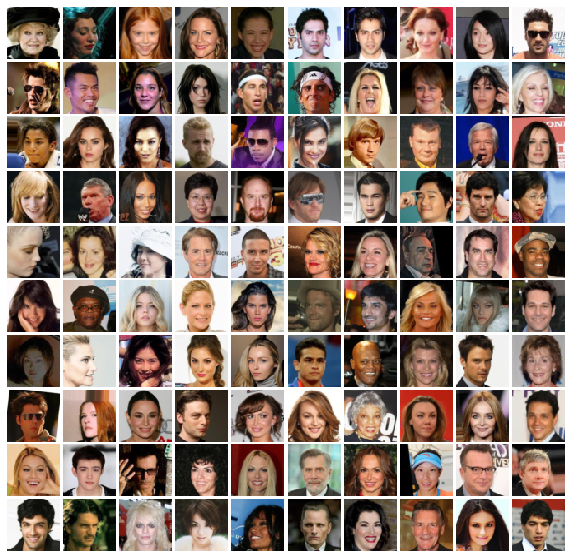

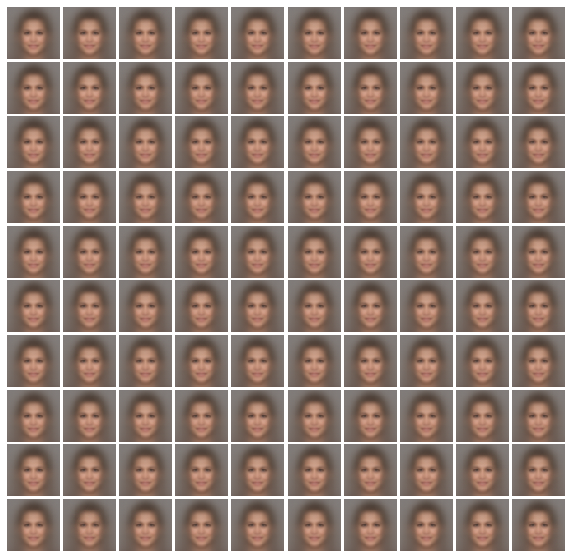

In [24]:
test_elbo()
show_results()

## Try Deep Criminal Sketch Artist

In [25]:
# Criminal Descriptions

# Criminal1: Man with gray hair, pale skin, and a mustache
Criminal_1_description = ['Male', 'Gray_Hair', 'Pale_Skin', 'Mustache', 'Goatee', '5_o_Clock_Shadow'] # The rest are false
# Criminal2: Young woman with black hair, heavy makeup, wearing a hat
Criminal_2_description = ['Young', 'Black_Hair', 'Heavy_Makeup', 'Wearing_Lipstick', 'Rosy_Cheeks', 'Wearing_Hat', 'No_Beard']
# Criminal3man with glasses and bushy eyebrows
Criminal_3_description = ['Male', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Bushy_Eyebrows']

In [26]:
# Get attribute tensors

ATTR_TO_IX_DICT  = {'Sideburns': 30, 'Black_Hair': 8, 'Wavy_Hair': 33, 'Young': 39, 'Heavy_Makeup': 18, 
                    'Blond_Hair': 9, 'Attractive': 2, '5_o_Clock_Shadow': 0, 'Wearing_Necktie': 38, 
                    'Blurry': 10, 'Double_Chin': 14, 'Brown_Hair': 11, 'Mouth_Slightly_Open': 21, 
                    'Goatee': 16, 'Bald': 4, 'Pointy_Nose': 27, 'Gray_Hair': 17, 'Pale_Skin': 26, 
                    'Arched_Eyebrows': 1, 'Wearing_Hat': 35, 'Receding_Hairline': 28, 'Straight_Hair': 32, 
                    'Big_Nose': 7, 'Rosy_Cheeks': 29, 'Oval_Face': 25, 'Bangs': 5, 'Male': 20, 'Mustache': 22, 
                    'High_Cheekbones': 19, 'No_Beard': 24, 'Eyeglasses': 15, 'Bags_Under_Eyes': 3, 
                    'Wearing_Necklace': 37, 'Wearing_Lipstick': 36, 'Big_Lips': 6, 'Narrow_Eyes': 23, 
                    'Chubby': 13, 'Smiling': 31, 'Bushy_Eyebrows': 12, 'Wearing_Earrings': 34}
def DescriptionToTensor(attr_list):
    attr_tensor = np.zeros(40)
    for attr_name in attr_list:
        attr_index = ATTR_TO_IX_DICT[attr_name]
        attr_tensor[attr_index] = 1
    attr_tensor = np.array([attr_tensor])
    attr_tensor = torch.from_numpy(attr_tensor).float().to("cuda")
    return attr_tensor

Criminal_1_attrs = DescriptionToTensor(Criminal_1_description)
Criminal_2_attrs = DescriptionToTensor(Criminal_2_description)
Criminal_3_attrs = DescriptionToTensor(Criminal_3_description)

In [31]:
# Get image from model
def sketch(model, attrs):
    model.eval()
    with torch.no_grad():
        image_recon, recon_attrs, mu, logvar = model(attrs=attrs)
        image_recon = image_recon.view(1, 3, 64, 64).detach().cpu()
        plt.imshow(image_recon[0].permute(1,2,0))

Man with gray hair, pale skin, and a mustache.


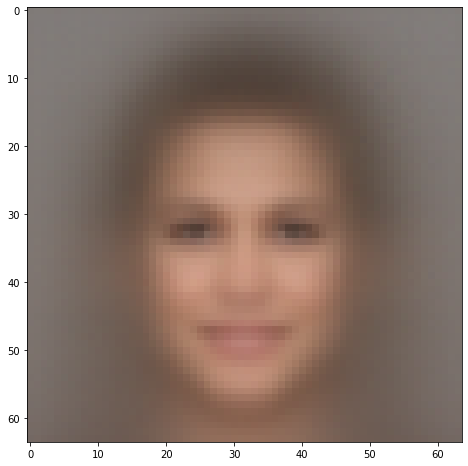

In [32]:
# Sketch criminal one
print("Man with gray hair, pale skin, and a mustache.")
sketch(model, Criminal_1_attrs)

Young woman with black hair, heavy makeup, wearing a hat.


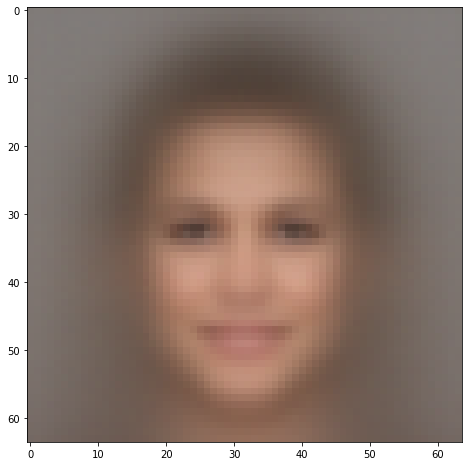

In [34]:
# Sketch criminal two
print("Young woman with black hair, heavy makeup, wearing a hat.")
sketch(model, Criminal_2_attrs)

Chubby young man with glasses and bushy eyebrows.


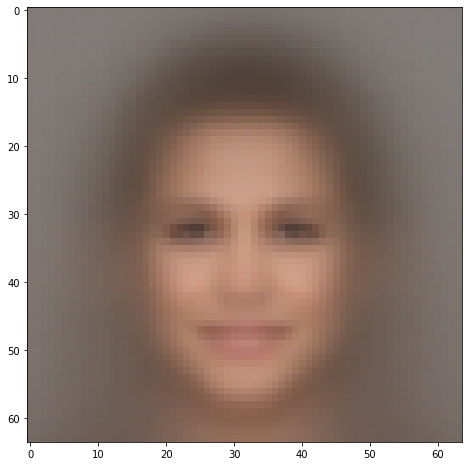

In [35]:
# Sketch criminal three
print("Chubby young man with glasses and bushy eyebrows.")
sketch(model, Criminal_3_attrs)